<a href="https://colab.research.google.com/github/SJP0308/MLTUTORIAL/blob/titanic/titanic4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Define Problem**

**It is your job to predict if a passenger survived the sinking of the Titanic or not.**
For each in the test set, you must predict a 0 or 1 value for the variable.

# **Evaluation**

Your score is the percentage of passengers you correctly predict. This is known as **accuracy.**

# **Download**

In [1]:
# 데이터셋 다운로드
def download_dataset(datafile_name):
  from google.colab import drive
  drive.mount('/content/drive')
  path = f'/content/drive/My Drive/{datafile_name}'
  train_df = pd.read_csv(f'{path}/train.csv')
  test_df = pd.read_csv(f'{path}/test.csv')
  print('데이터 다운로드 완료!')
  return pd.concat([train_df, test_df], ignore_index=True)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# 경고 메시지를 무시하도록 설정
warnings.filterwarnings('ignore')

# 플롯을 인라인으로 표시하도록 설정
%matplotlib inline

df = download_dataset('titanic')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 다운로드 완료!


# **Features**

In [3]:
def fill_age_with_mean(age, title):
    if pd.isnull(age):
        mean_age = {'Master': 4, 'Miss': 21, 'Mr': 33, 'Mrs':35}
        return mean_age.get(title, age)
    return age

def extract_age_group(age):
    if pd.notnull(age):
        return int((age-0.01)//10)

def fill_fare_with_mean(Fare, Pclass):
    if pd.isnull(Fare):
        mean_fares = {1: 87.51, 2: 21.18, 3: 13.30}
        return mean_fares.get(Pclass, Fare)
    return round(Fare, 2)

def ticket_number(x):
    return x.split(" ")[-1]

def ticket_item(x):
    items = x.split(" ")
    if len(items) == 1:
      return "NONE"
    return "_".join(items[0:-1])

In [4]:
title_mapping = {'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss', 'Dr': 'Mr', 'Major': 'Mr', 'Lady': 'Mrs',
    'Countess': 'Mrs', 'Jonkheer': 'Mr', 'Col': 'Mr', 'Rev': 'Mr', 'Capt': 'Mr', 'Sir': 'Mr',
    'Don': 'Mr', 'Dona': 'Mrs'}
df['Title'] = df['Name'].str.extract(' ([A-Z][a-z]+)\.')
df['Title'].replace(title_mapping, inplace=True)

df['Age'] = df.apply(lambda row: fill_age_with_mean(row['Age'], row['Title']), axis=1)
df['AgeGroup'] = df['Age'].apply(extract_age_group)

df['FamilySize'] = df['SibSp'] + df['Parch']
df['IsAlone'] = (df['FamilySize']==1).astype(int)

df['Fare'] = df.apply(lambda row: fill_fare_with_mean(row['Fare'], row['Pclass']), axis=1)

df['Embarked'] = df['Embarked'].fillna('S')

df['Ticket_number'] = df['Ticket'].apply(ticket_number)
df['Ticket_item'] = df['Ticket'].apply(ticket_item)

In [5]:
for col in ['Pclass', 'AgeGroup', 'FamilySize', 'IsAlone']:
  df[col] = df[col].apply(str)

df = df.drop(['PassengerId', 'Name', 'Age', 'SibSp',	'Parch', 'Cabin', 'Ticket'], axis=1)

# **Data processing**

In [6]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

df['Fare'] = boxcox1p(df['Fare'], boxcox_normmax(df['Fare']+1))

In [7]:
for column in ['Pclass', 'Sex', 'Embarked', 'Title', 'AgeGroup', 'FamilySize','IsAlone', 'Ticket_number', 'Ticket_item']:
  df = pd.get_dummies(df, columns=[column], prefix=column)

In [8]:
from sklearn.preprocessing import RobustScaler

rbst_scaler=RobustScaler()
X_train = rbst_scaler.fit_transform(df[df['Survived'].notnull()].drop('Survived', axis=1).values)
X_test = rbst_scaler.transform(df[df['Survived'].isnull()].drop('Survived', axis=1).values)
target_label = df[df['Survived'].notnull()]['Survived'].values.astype(int)

# **model**

```pip install -q optuna```

```
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import optuna
from optuna.samplers import TPESampler

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial, X, y):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }
    
    cv_scores = []  
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]  
        y_train, y_val = y[train_idx], y[val_idx]  
        
        model = XGBClassifier(**param, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        cv_scores.append(accuracy)

    return np.mean(cv_scores)

study = optuna.create_study(study_name='XGBClassifier_KFold', direction='maximize', sampler=TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, X_train, target_label), n_trials=100)

print()
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)
```

Best Score: 0.8339150084740444

Best trial: {'n_estimators': 53, 'max_depth': 9, 'learning_rate': 0.04468804077976062, 'subsample': 0.619925895839222, 'colsample_bytree': 0.9247026894918343, 'gamma': 4.703389502382125}


```
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna
from optuna.samplers import TPESampler

cv = KFold(n_splits=5, shuffle=True, random_state=84)

def objective(trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    }

    cv_scores = []  

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]  
        y_train, y_val = y[train_idx], y[val_idx]  

        model = RandomForestClassifier(**param, random_state=84)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        cv_scores.append(accuracy)

    return np.mean(cv_scores)

study = optuna.create_study(study_name='RandomForest_KFold', direction='maximize', sampler=TPESampler(seed=84))
study.optimize(lambda trial: objective(trial, X_train, target_label), n_trials=100)

print()
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)
```


Best Score: 0.8373171803402173

Best trial: {'n_estimators': 168, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}

```
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import optuna
from optuna.samplers import TPESampler

cv = KFold(n_splits=5, shuffle=True, random_state=126)

def objective(trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }

    cv_scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = LGBMClassifier(**param, verbosity=-1, random_state=126)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        cv_scores.append(accuracy)

    return np.mean(cv_scores)

study = optuna.create_study(study_name='LGBM_KFold', direction='maximize', sampler=TPESampler(seed=126))
study.optimize(lambda trial: objective(trial, X_train, target_label), n_trials=100)

print()
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)
```



Best Score: 0.8417487916640513

Best trial: {'n_estimators': 480, 'max_depth': 2, 'learning_rate': 0.2227965278616023, 'num_leaves': 139, 'min_child_samples': 48, 'subsample': 0.6453476617376205, 'colsample_bytree': 0.9580024676190495}

In [9]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

xgb_param={'n_estimators': 53, 'max_depth': 9, 'learning_rate': 0.04468804077976062, 'subsample': 0.619925895839222,
           'colsample_bytree': 0.9247026894918343, 'gamma': 4.703389502382125}
rf_param={'n_estimators': 168, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}
lgb_param={'n_estimators': 480, 'max_depth': 2, 'learning_rate': 0.2227965278616023, 'num_leaves': 139,
           'min_child_samples': 48, 'subsample': 0.6453476617376205, 'colsample_bytree': 0.9580024676190495}

xgb = XGBClassifier(**xgb_param, random_state=42).fit(X_train, target_label)
rf = RandomForestClassifier(**rf_param, random_state=84).fit(X_train, target_label)
lgb = LGBMClassifier(**lgb_param, verbosity=-1, random_state=126).fit(X_train, target_label)

# **Ensemble**

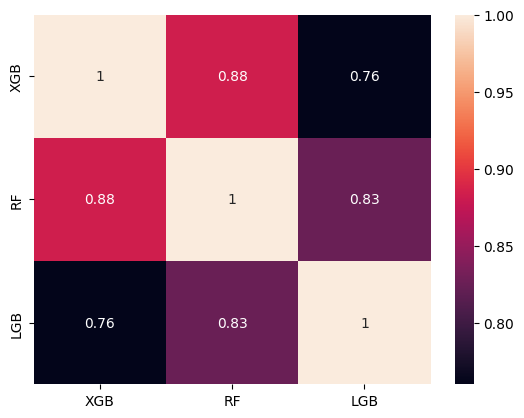

In [10]:
test_XGB = pd.Series(xgb.predict(X_test), name="XGB")
test_RF = pd.Series(rf.predict(X_test), name="RF")
test_LGB = pd.Series(lgb.predict(X_test), name="LGB")

ensemble_results = pd.concat([test_XGB, test_RF, test_LGB],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

In [11]:
test_XGB_prob = xgb.predict_proba(X_test)[:,1]
test_RF_prob = rf.predict_proba(X_test)[:,1]
test_LGB_prob = lgb.predict_proba(X_test)[:,1]

ensemble_probs = (0.3*test_XGB_prob + 0.4*test_RF_prob + 0.3*test_LGB_prob)
pred = (ensemble_probs >= 0.5).astype(int)
submission = pd.read_csv('/content/drive/My Drive/titanic/gender_submission.csv')
submission['Survived'] = pred
submission.to_csv('./ensemble_answer.csv', index=False)

In [12]:
from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[('XGB', xgb), ('RF',rf), ('LGB', lgb)], voting='soft', n_jobs=-1)
votingC = votingC.fit(X_train, target_label)
vote = pd.Series(votingC.predict(X_test))
submission = pd.read_csv('/content/drive/My Drive/titanic/gender_submission.csv')
submission['Survived'] = vote.astype(int)
submission.to_csv('./vote_answer.csv', index=False)

In [13]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

clf1 = xgb
clf2 = rf
clf3 = lgb

sc = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=LogisticRegression())
stacking = sc.fit(X_train, target_label)
stack = stacking.predict(X_test)

submission = pd.read_csv('/content/drive/My Drive/titanic/gender_submission.csv')
submission['Survived'] = stack.astype(int)
submission.to_csv('./stack_answer.csv', index=False)

In [14]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from mlxtend.classifier import StackingCVClassifier

# KFold 정의
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# 개별 분류기 정의
ridge = make_pipeline(RobustScaler(), LogisticRegressionCV(cv=kfolds))
lasso = make_pipeline(RobustScaler(), LogisticRegressionCV(cv=kfolds))
enet = make_pipeline(RobustScaler(), LogisticRegressionCV(cv=kfolds))
svc = make_pipeline(RobustScaler(), SVC(C=20, gamma=0.0003, probability=True))

# 스태킹 모델 정의
stack_gen = StackingCVClassifier(classifiers=(ridge, lasso, enet, svc, rf, xgb, lgb),
                                  meta_classifier=LogisticRegressionCV(),
                                  use_features_in_secondary=True)

# 모델 학습
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(target_label))

# 각 모델 개별 학습
elastic_model = enet.fit(X_train, target_label)
lasso_model = lasso.fit(X_train, target_label)
ridge_model = ridge.fit(X_train, target_label)
svc_model = svc.fit(X_train, target_label)
rf_model = rf.fit(X_train, target_label)
xgb_model = xgb.fit(X_train, target_label)
lgb_model = lgb.fit(X_train, target_label)

# 예측 함수 정의
def blend_models_predict(X):
    elastic_prob = elastic_model.predict_proba(X)[:, 1]
    lasso_prob = lasso_model.predict_proba(X)[:, 1]
    ridge_prob = ridge_model.predict_proba(X)[:, 1]
    svc_prob = svc_model.predict_proba(X)[:, 1]
    rf_prob = rf_model.predict_proba(X)[:, 1]
    xgb_prob = xgb_model.predict_proba(X)[:, 1]
    lgb_prob = lgb_model.predict_proba(X)[:, 1]
    stack_prob = stack_gen_model.predict_proba(X)[:, 1]

    blended_prob = (0.1 * elastic_prob +
                    0.1 * lasso_prob +
                    0.1 * ridge_prob +
                    0.1 * svc_prob +
                    0.15 * rf_prob +
                    0.1 * xgb_prob +
                    0.1 * lgb_prob +
                    0.25 * stack_prob)

    return (blended_prob >= 0.5).astype(int)

# 데이터 로드 및 예측
blend = blend_models_predict(X_test)
submission = pd.read_csv('/content/drive/My Drive/titanic/gender_submission.csv')
submission['Survived'] = blend.astype(int)
submission.to_csv('./blend_answer.csv', index=False)